In [23]:
import pandas as pd
import numpy as np
import kagglehub
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

In [4]:

# Download latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fake-and-real-news-dataset


In [5]:

# Load datasets
fake_df = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")
true_df = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")

# Add labels
fake_df['label'] = 1  # Fake news
true_df['label'] = 0  # Real news

In [8]:
#fake_df.head()
true_df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [9]:
# Combine datasets
df = pd.concat([fake_df, true_df], axis=0)

# Shuffle the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",1
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",0
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",0
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",1
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",0


***re***: Python's regex module for pattern matching (like removing URLs or punctuation).

***nltk***: Natural Language Toolkit, used for NLP tasks.

***stopwords***: Common words like "the", "and", "is" that don't add much meaning.

***WordNetLemmatizer***: Used to reduce words to their base or dictionary form.

**Stopwords** are common words that appear very frequently in a language but usually don’t add much meaning ex : "the", "is", "in", "and".

"The cat is sitting on the mat" => "cat sitting mat"

**WordNet** is a large English dictionary database used in NLP

**Lemmatization** uses WordNet to reduce a word to its base form (lemma) — the word you'd find in a dictionary.

Examples:
"running" → "run"

"better" → "good"

"mice" → "mouse"

"was" → "be"

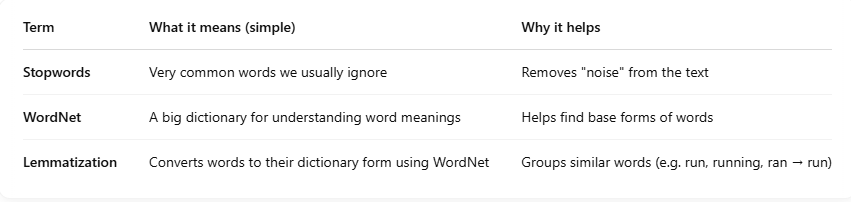



**Why combine title + text?**

More context: The title often summarizes or highlights the key idea of the text — combining both gives the model more complete information.

Improves accuracy: Including the title can help the model understand the topic better, especially when the body text is short or ambiguous.

Natural language flow: In real-world content (like news articles or posts), the title and text are usually consumed together — so modeling them together makes sense.

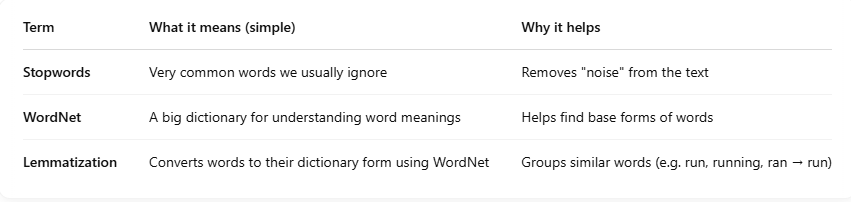

In [13]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs, special chars, and punctuation
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize and lemmatize
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Combine title and text
df['combined_text'] = df['title'] + ' ' + df['text']
df['cleaned_text'] = df['combined_text'].apply(preprocess_text)

df['cleaned_text'].head()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    ben stein call th circuit court committed coup...
1    trump drop steve bannon national security coun...
2    puerto rico expects u lift jones act shipping ...
3    oops trump accidentally confirmed leaked israe...
4    donald trump head scotland reopen golf resort ...
Name: cleaned_text, dtype: object


**X** is the input features (cleaned text), and y is the target labels.

**train_test_split** splits the data into training (80%) and testing (20%) sets.

stratify=y ensures class distribution stays balanced in both sets; **random_state**=42 makes the split reproducible.

In [17]:
X = df['cleaned_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [21]:
X.head()
#y.head()

0    ben stein call th circuit court committed coup...
1    trump drop steve bannon national security coun...
2    puerto rico expects u lift jones act shipping ...
3    oops trump accidentally confirmed leaked israe...
4    donald trump head scotland reopen golf resort ...
Name: cleaned_text, dtype: object

**Text Vectorization**

Text Vectorization is the process of converting raw text data into numerical representations (vectors) that machine learning models can understand and process. Since most algorithms (like Logistic Regression, SVM, etc.) work with numbers—not text—this step is critical for training models on text-based datasets like your fake news detection task.



In [22]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

**Logistic Regression** is a machine learning algorithm used for classification, especially binary classification

If probability > 0.5 → class 1 (e.g., "spam")
If probability ≤ 0.5 → class 0 (e.g., "not spam")

Logistic Regression uses an optimization algorithm (like Gradient Descent) 
max_iter sets the maximum number of these iterations.



In [24]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred)}")

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4284
           1       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

AUC-ROC: 0.9908452591712438
